In [1]:
import numpy as np
from model_aug_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint"
sample_dir = "./out/shiftx_5px_aug_inplace_lr0.0002/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

loading mnist...
 [*] Reading checkpoints... ./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


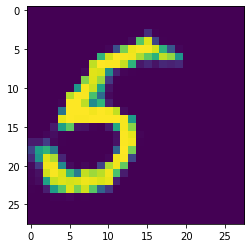

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/walk_train_aug/shiftx_l2_git{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 6)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
#             Loss_sum = Loss_sum + curr_loss
#             loss_values.append(curr_loss)

#             elapsed_time = time.time() - start_time

#             logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))
                
#             alpha_list.append(alpha_val)

#             if (optim_iter % 100 == 0) and (optim_iter > 0):
#                 saver.save(sess, './shift_l2_git/model_{}.ckpt'.format(optim_iter*batch_size), write_meta_graph=False, write_state=False)

#             optim_iter = optim_iter+1
            
#     if optim_iter > 0:
#         print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
#     saver.save(sess, "./shift_l2_git/model_{}_final.ckpt".format(optim_iter*batch_size), write_meta_graph=False, write_state=False)
#     return loss_values
            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-10 13:44:22,704 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.3045485019683838, 0, 0, 0.23227344453334808, 3
2019-09-10 13:44:22,711 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006319284439086914, 0, 10, 0.17283408343791962, -4
2019-09-10 13:44:22,718 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005625486373901367, 0, 20, 0.11371823400259018, 1
2019-09-10 13:44:22,725 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006306886672973633, 0, 30, 0.15256895124912262, -3
2019-09-10 13:44:22,732 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067174434661865234, 0, 40, 0.2829360067844391, 5
2019-09-10 13:44:22,738 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005937814712524414, 0, 50, 0.1023043766617775, -2
2019-09-10 13:44:22,745 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006049156188964844, 0, 60, 0.1226835772395134, -3
2019-09-10 13:44:22,753 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006582021713256836, 0, 70, 0.15575049817562103, -5
2019-09-10 13:44:22,761 [MainThr

2019-09-10 13:44:23,184 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006983041763305664, 0, 680, 0.15861938893795013, 3
2019-09-10 13:44:23,191 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059549808502197266, 0, 690, 0.13284824788570404, -5
2019-09-10 13:44:23,198 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006139516830444336, 0, 700, 0.056471675634384155, 1
2019-09-10 13:44:23,207 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008662700653076172, 0, 710, 0.06204850971698761, -1
2019-09-10 13:44:23,214 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006365537643432617, 0, 720, 0.11375214159488678, 2
2019-09-10 13:44:23,222 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007291078567504883, 0, 730, 0.21365299820899963, 4
2019-09-10 13:44:23,229 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006737232208251953, 0, 740, 0.05818995088338852, 1
2019-09-10 13:44:23,238 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007727861404418945, 0, 750, 0.1355351358652115, -4
2019-09-10 13:44:23,

2019-09-10 13:44:23,732 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01006007194519043, 0, 1350, 0.03368588164448738, -1
2019-09-10 13:44:23,741 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00729060173034668, 0, 1360, 0.17473913729190826, 5
2019-09-10 13:44:23,750 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008852720260620117, 0, 1370, 0.14948225021362305, -5
2019-09-10 13:44:23,760 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009225606918334961, 0, 1380, 0.1147909089922905, 3
2019-09-10 13:44:23,773 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01128244400024414, 0, 1390, 0.15776541829109192, 4
2019-09-10 13:44:23,781 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007238626480102539, 0, 1400, 0.06889666616916656, 2
2019-09-10 13:44:23,789 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0073397159576416016, 0, 1410, 0.10116223990917206, -2
2019-09-10 13:44:23,797 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007509946823120117, 0, 1420, 0.16934001445770264, 5
2019-09-10 13:44

2019-09-10 13:44:24,255 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007041454315185547, 0, 2010, 0.05316782370209694, -2
2019-09-10 13:44:24,266 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009409427642822266, 0, 2020, 0.05275462567806244, 2
2019-09-10 13:44:24,276 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008772850036621094, 0, 2030, 0.09968194365501404, -3
2019-09-10 13:44:24,291 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014058828353881836, 0, 2040, 0.1529296487569809, -5
2019-09-10 13:44:24,300 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007608890533447266, 0, 2050, 0.09482453018426895, -3
2019-09-10 13:44:24,308 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006617069244384766, 0, 2060, 0.1406640112400055, 5
2019-09-10 13:44:24,315 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006529331207275391, 0, 2070, 0.13607357442378998, -5
2019-09-10 13:44:24,323 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069963932037353516, 0, 2080, 0.16507667303085327, 5
2019-09-10 1

2019-09-10 13:44:24,782 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006572246551513672, 0, 2680, 0.06156217306852341, 2
2019-09-10 13:44:24,797 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013861894607543945, 0, 2690, 0.018094927072525024, 1
2019-09-10 13:44:24,805 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006859302520751953, 0, 2700, 0.11340712010860443, -4
2019-09-10 13:44:24,813 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00684809684753418, 0, 2710, 0.024381576105952263, 1
2019-09-10 13:44:24,820 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00666356086730957, 0, 2720, 0.1463322937488556, -5
2019-09-10 13:44:24,828 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0075986385345458984, 0, 2730, 0.10100384801626205, -3
2019-09-10 13:44:24,836 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006458759307861328, 0, 2740, 0.10519382357597351, -5
2019-09-10 13:44:24,844 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0076901912689208984, 0, 2750, 0.08749891817569733, 3
2019-09-10 

2019-09-10 13:44:25,297 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006725311279296875, 0, 3340, 0.08793053030967712, 4
2019-09-10 13:44:25,304 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066111087799072266, 0, 3350, 0.02432875707745552, -1
2019-09-10 13:44:25,312 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00678253173828125, 0, 3360, 0.14034973084926605, -5
2019-09-10 13:44:25,319 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067098140716552734, 0, 3370, 0.04519761726260185, 2
2019-09-10 13:44:25,327 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006815910339355469, 0, 3380, 0.08289986848831177, 3
2019-09-10 13:44:25,335 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007818937301635742, 0, 3390, 0.12848727405071259, 5
2019-09-10 13:44:25,346 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009336709976196289, 0, 3400, 0.0229222122579813, 1
2019-09-10 13:44:25,355 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007851600646972656, 0, 3410, 0.09430953860282898, 3
2019-09-10 13:

Loss: [0.013845058236271144, 0.010109811894595623, 0.008297054134309291, 0.008043441908434033]
2019-09-10 13:44:25,868 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006482839584350586, 0, 4010, 0.06349905580282211, 3
2019-09-10 13:44:25,875 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006684303283691406, 0, 4020, 0.0629759430885315, -2
2019-09-10 13:44:25,883 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006395816802978516, 0, 4030, 0.10920602828264236, -4
2019-09-10 13:44:25,890 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006921529769897461, 0, 4040, 0.02553980052471161, 1
2019-09-10 13:44:25,899 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007830619812011719, 0, 4050, 0.1278669387102127, -5
2019-09-10 13:44:25,908 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008060693740844727, 0, 4060, 0.027930667623877525, -1
2019-09-10 13:44:25,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006499767303466797, 0, 4070, 0.13051915168762207, 5
2019-09-10 13:44:25,922 [MainThread  ] [I

2019-09-10 13:44:26,421 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059719085693359375, 0, 4670, 0.017944809049367905, 1
2019-09-10 13:44:26,427 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061833858489990234, 0, 4680, 0.07689999043941498, 4
2019-09-10 13:44:26,434 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005848884582519531, 0, 4690, 0.10525164753198624, -4
2019-09-10 13:44:26,443 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008499383926391602, 0, 4700, 0.08174542337656021, -3
2019-09-10 13:44:26,450 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006354808807373047, 0, 4710, 0.10707388073205948, 5
2019-09-10 13:44:26,457 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006159543991088867, 0, 4720, 0.08295299112796783, -4
2019-09-10 13:44:26,464 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006678342819213867, 0, 4730, 0.026647716760635376, 1
2019-09-10 13:44:26,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006064653396606445, 0, 4740, 0.04287446290254593, 2
2019-09-1

2019-09-10 13:44:26,917 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006636142730712891, 0, 5330, 0.100438691675663, 4
2019-09-10 13:44:26,924 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00665736198425293, 0, 5340, 0.01723369210958481, -1
2019-09-10 13:44:26,931 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006167888641357422, 0, 5350, 0.053300511091947556, 2
2019-09-10 13:44:26,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00541996955871582, 0, 5360, 0.09197165817022324, 4
2019-09-10 13:44:26,944 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006383657455444336, 0, 5370, 0.11749747395515442, 5
2019-09-10 13:44:26,951 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006096839904785156, 0, 5380, 0.05872521176934242, 3
2019-09-10 13:44:26,958 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005879640579223633, 0, 5390, 0.02138475701212883, -1
2019-09-10 13:44:26,965 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00604557991027832, 0, 5400, 0.045890044420957565, 2
2019-09-10 13:44:

2019-09-10 13:44:27,441 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008234977722167969, 0, 6000, 0.09971455484628677, 5
Loss: [0.013845058236271144, 0.010109811894595623, 0.008297054134309291, 0.008043441908434033, 0.007036673218011856, 0.006506281100213528]
2019-09-10 13:44:27,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008471488952636719, 0, 6010, 0.07622164487838745, -3
2019-09-10 13:44:27,460 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00829625129699707, 0, 6020, 0.0782085433602333, 4
2019-09-10 13:44:27,469 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0074024200439453125, 0, 6030, 0.01988089270889759, -1
2019-09-10 13:44:27,481 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010988950729370117, 0, 6040, 0.06890153139829636, 3
2019-09-10 13:44:27,491 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008459329605102539, 0, 6050, 0.04227679595351219, -2
2019-09-10 13:44:27,502 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010616779327392578, 0, 6060, 0.06984018534421921, 

2019-09-10 13:44:27,965 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058901309967041016, 0, 6660, 0.018186263740062714, -1
2019-09-10 13:44:27,971 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005341529846191406, 0, 6670, 0.0482819490134716, 2
2019-09-10 13:44:27,977 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005361080169677734, 0, 6680, 0.07733775675296783, 4
2019-09-10 13:44:27,983 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005814313888549805, 0, 6690, 0.08347701281309128, -4
2019-09-10 13:44:27,990 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00609135627746582, 0, 6700, 0.11624578386545181, 4
2019-09-10 13:44:27,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006224870681762695, 0, 6710, 0.054453108459711075, -3
2019-09-10 13:44:28,004 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006423473358154297, 0, 6720, 0.08283187448978424, -4
2019-09-10 13:44:28,011 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061414241790771484, 0, 6730, 0.1057543084025383, 5
2019-09-10 

2019-09-10 13:44:28,399 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006849765777587891, 0, 7320, 0.04997009411454201, -2
2019-09-10 13:44:28,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007290363311767578, 0, 7330, 0.05634940788149834, 3
2019-09-10 13:44:28,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005681514739990234, 0, 7340, 0.021212680265307426, -1
2019-09-10 13:44:28,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060460567474365234, 0, 7350, 0.08819126337766647, 5
2019-09-10 13:44:28,427 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006242513656616211, 0, 7360, 0.03567130118608475, -2
2019-09-10 13:44:28,434 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006209135055541992, 0, 7370, 0.08625520765781403, -4
2019-09-10 13:44:28,443 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00780487060546875, 0, 7380, 0.08622230589389801, -5
2019-09-10 13:44:28,455 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011301279067993164, 0, 7390, 0.01710435003042221, -1
2019-09-1

2019-09-10 13:44:28,867 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005846977233886719, 0, 7990, 0.09839601814746857, 4
2019-09-10 13:44:28,875 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006423234939575195, 0, 8000, 0.018496377393603325, 1
Loss: [0.013845058236271144, 0.010109811894595623, 0.008297054134309291, 0.008043441908434033, 0.007036673218011856, 0.006506281100213528, 0.006199369275942445, 0.006328315030783415]
2019-09-10 13:44:28,881 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0052433013916015625, 0, 8010, 0.032164979726076126, -2
2019-09-10 13:44:28,887 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00591588020324707, 0, 8020, 0.10956632345914841, -5
2019-09-10 13:44:28,896 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007890939712524414, 0, 8030, 0.09027010947465897, -4
2019-09-10 13:44:28,903 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068912506103515625, 0, 8040, 0.09242308139801025, 4
2019-09-10 13:44:28,909 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00

2019-09-10 13:44:29,323 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00597381591796875, 0, 8640, 0.11420109122991562, -5
2019-09-10 13:44:29,330 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005719661712646484, 0, 8650, 0.056158050894737244, 3
2019-09-10 13:44:29,336 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005757331848144531, 0, 8660, 0.11524270474910736, 5
2019-09-10 13:44:29,343 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005749225616455078, 0, 8670, 0.020747432485222816, 1
2019-09-10 13:44:29,350 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006398916244506836, 0, 8680, 0.09761395305395126, 5
2019-09-10 13:44:29,359 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008111715316772461, 0, 8690, 0.04725942015647888, -2
2019-09-10 13:44:29,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008721351623535156, 0, 8700, 0.05292078107595444, -3
2019-09-10 13:44:29,376 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00620579719543457, 0, 8710, 0.021178916096687317, 1
2019-09-10 1

2019-09-10 13:44:29,777 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007094621658325195, 0, 9290, 0.0458143949508667, 2
2019-09-10 13:44:29,785 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007133007049560547, 0, 9300, 0.06825225055217743, -3
2019-09-10 13:44:29,791 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005228281021118164, 0, 9310, 0.02312934398651123, -1
2019-09-10 13:44:29,797 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005271434783935547, 0, 9320, 0.06065836921334267, -3
2019-09-10 13:44:29,803 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005418300628662109, 0, 9330, 0.047674719244241714, -2
2019-09-10 13:44:29,809 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005538463592529297, 0, 9340, 0.09571142494678497, -5
2019-09-10 13:44:29,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005469560623168945, 0, 9350, 0.11523950845003128, 4
2019-09-10 13:44:29,821 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0052525997161865234, 0, 9360, 0.056094493716955185, -2
2019-09-

2019-09-10 13:44:30,182 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007220745086669922, 0, 9960, 0.017680717632174492, -1
2019-09-10 13:44:30,189 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006119966506958008, 0, 9970, 0.05853424221277237, -3
2019-09-10 13:44:30,197 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007395267486572266, 0, 9980, 0.11983201652765274, 5
2019-09-10 13:44:30,203 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005855560302734375, 0, 9990, 0.06696783006191254, 3
2019-09-10 13:44:30,215 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010569095611572266, 0, 10000, 0.05687176063656807, 3
Loss: [0.013845058236271144, 0.010109811894595623, 0.008297054134309291, 0.008043441908434033, 0.007036673218011856, 0.006506281100213528, 0.006199369275942445, 0.006328315030783415, 0.0061222101859748366, 0.006011591034010053]
2019-09-10 13:44:30,224 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00797271728515625, 0, 10010, 0.04243330657482147, -2
2019-09-10 13:44:30,231 [Main

2019-09-10 13:44:30,660 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00815892219543457, 0, 10610, 0.11124938726425171, -5
2019-09-10 13:44:30,667 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006491184234619141, 0, 10620, 0.07367343455553055, -3
2019-09-10 13:44:30,673 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005774497985839844, 0, 10630, 0.04759391397237778, 2
2019-09-10 13:44:30,679 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005426645278930664, 0, 10640, 0.08104448765516281, 4
2019-09-10 13:44:30,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005852937698364258, 0, 10650, 0.04654286056756973, 2
2019-09-10 13:44:30,692 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005993366241455078, 0, 10660, 0.07989427447319031, 5
2019-09-10 13:44:30,698 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005372285842895508, 0, 10670, 0.020780226215720177, 1
2019-09-10 13:44:30,704 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005341291427612305, 0, 10680, 0.11555281281471252, 5
2019-0

2019-09-10 13:44:31,136 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059201717376708984, 0, 11250, 0.054739926010370255, 3
2019-09-10 13:44:31,143 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061321258544921875, 0, 11260, 0.07558601349592209, 3
2019-09-10 13:44:31,151 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071258544921875, 0, 11270, 0.06004883721470833, 4
2019-09-10 13:44:31,158 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006239414215087891, 0, 11280, 0.07582332193851471, 4
2019-09-10 13:44:31,167 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007507801055908203, 0, 11290, 0.019786430522799492, -1
2019-09-10 13:44:31,174 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006373405456542969, 0, 11300, 0.018609581515192986, 1
2019-09-10 13:44:31,180 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006060361862182617, 0, 11310, 0.08136888593435287, -3
2019-09-10 13:44:31,187 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006003379821777344, 0, 11320, 0.052361879497766495, -2
2

2019-09-10 13:44:31,623 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006507396697998047, 0, 11910, 0.09684599190950394, 5
2019-09-10 13:44:31,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006152629852294922, 0, 11920, 0.08176484704017639, -4
2019-09-10 13:44:31,637 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006058216094970703, 0, 11930, 0.038493648171424866, 2
2019-09-10 13:44:31,643 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005590677261352539, 0, 11940, 0.014266039244830608, 1
2019-09-10 13:44:31,650 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061032772064208984, 0, 11950, 0.10662218183279037, -5
2019-09-10 13:44:31,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009067535400390625, 0, 11960, 0.018239766359329224, -1
2019-09-10 13:44:31,668 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007566213607788086, 0, 11970, 0.10311540216207504, -5
2019-09-10 13:44:31,675 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006422758102416992, 0, 11980, 0.06356611847877502, 3


2019-09-10 13:44:32,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007581949234008789, 0, 12550, 0.04044507071375847, -2
2019-09-10 13:44:32,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006620883941650391, 0, 12560, 0.058794207870960236, 3
2019-09-10 13:44:32,110 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006356000900268555, 0, 12570, 0.016066746786236763, 1
2019-09-10 13:44:32,117 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006044149398803711, 0, 12580, 0.04953116551041603, -2
2019-09-10 13:44:32,125 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006807088851928711, 0, 12590, 0.09576791524887085, 5
2019-09-10 13:44:32,133 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006799936294555664, 0, 12600, 0.07576899975538254, -4
2019-09-10 13:44:32,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068700313568115234, 0, 12610, 0.03872119262814522, 2
2019-09-10 13:44:32,148 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007065773010253906, 0, 12620, 0.024177994579076767, -1


2019-09-10 13:44:32,591 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006245136260986328, 0, 13190, 0.01590004935860634, -1
2019-09-10 13:44:32,599 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071353912353515625, 0, 13200, 0.0766109898686409, 4
2019-09-10 13:44:32,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006547689437866211, 0, 13210, 0.042204443365335464, -2
2019-09-10 13:44:32,615 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007587432861328125, 0, 13220, 0.04035923629999161, 2
2019-09-10 13:44:32,624 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007926464080810547, 0, 13230, 0.11126725375652313, 5
2019-09-10 13:44:32,633 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00750279426574707, 0, 13240, 0.07561802119016647, -3
2019-09-10 13:44:32,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006974220275878906, 0, 13250, 0.05261540412902832, -3
2019-09-10 13:44:32,649 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069882869720458984, 0, 13260, 0.1095489114522934, -5
201

2019-09-10 13:44:33,139 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007565736770629883, 0, 13850, 0.0653676688671112, -3
2019-09-10 13:44:33,147 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007675647735595703, 0, 13860, 0.10923168063163757, -5
2019-09-10 13:44:33,155 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069463253021240234, 0, 13870, 0.09300623089075089, 5
2019-09-10 13:44:33,163 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006763458251953125, 0, 13880, 0.06341470032930374, 3
2019-09-10 13:44:33,171 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006852865219116211, 0, 13890, 0.03581922873854637, -2
2019-09-10 13:44:33,179 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006704568862915039, 0, 13900, 0.09679312258958817, -5
2019-09-10 13:44:33,187 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0074367523193359375, 0, 13910, 0.03375529497861862, -2
2019-09-10 13:44:33,194 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006420135498046875, 0, 13920, 0.02618320658802986, 2
20

2019-09-10 13:44:33,620 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006979703903198242, 0, 14490, 0.09806650131940842, -5
2019-09-10 13:44:33,627 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006103992462158203, 0, 14500, 0.07744430750608444, 5
2019-09-10 13:44:33,634 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005577802658081055, 0, 14510, 0.07191231846809387, 3
2019-09-10 13:44:33,640 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0056798458099365234, 0, 14520, 0.09427755326032639, 5
2019-09-10 13:44:33,647 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005634784698486328, 0, 14530, 0.09117860347032547, -5
2019-09-10 13:44:33,653 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005429267883300781, 0, 14540, 0.04420340433716774, 2
2019-09-10 13:44:33,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005833148956298828, 0, 14550, 0.014852487482130527, -1
2019-09-10 13:44:33,666 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005779266357421875, 0, 14560, 0.018125133588910103, -1
2

2019-09-10 13:44:34,093 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006650447845458984, 0, 15130, 0.04582700878381729, 3
2019-09-10 13:44:34,100 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006422758102416992, 0, 15140, 0.01588919386267662, 1
2019-09-10 13:44:34,109 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007594585418701172, 0, 15150, 0.037903930991888046, -2
2019-09-10 13:44:34,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007882356643676758, 0, 15160, 0.08089666068553925, 5
2019-09-10 13:44:34,125 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006337404251098633, 0, 15170, 0.038828689604997635, 2
2019-09-10 13:44:34,131 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0056362152099609375, 0, 15180, 0.0869491770863533, -4
2019-09-10 13:44:34,137 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0054585933685302734, 0, 15190, 0.10026347637176514, -5
2019-09-10 13:44:34,145 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007183551788330078, 0, 15200, 0.09523121267557144, 5
20

2019-09-10 13:44:34,586 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068361759185791016, 0, 15790, 0.0377027727663517, -3
2019-09-10 13:44:34,595 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007602691650390625, 0, 15800, 0.03427113592624664, -2
2019-09-10 13:44:34,604 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007641315460205078, 0, 15810, 0.1087566688656807, -5
2019-09-10 13:44:34,612 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007216691970825195, 0, 15820, 0.09217127412557602, 5
2019-09-10 13:44:34,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007876396179199219, 0, 15830, 0.05324331298470497, -3
2019-09-10 13:44:34,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007914543151855469, 0, 15840, 0.08969787508249283, 5
2019-09-10 13:44:34,639 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008203268051147461, 0, 15850, 0.01660982146859169, 1
2019-09-10 13:44:34,649 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0082244873046875, 0, 15860, 0.07921645790338516, -4
2019-0

2019-09-10 13:44:35,116 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061838626861572266, 0, 16420, 0.1017550677061081, -5
2019-09-10 13:44:35,122 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00603175163269043, 0, 16430, 0.02292475290596485, -1
2019-09-10 13:44:35,132 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008795499801635742, 0, 16440, 0.016578786075115204, 1
2019-09-10 13:44:35,141 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008475065231323242, 0, 16450, 0.0932292491197586, 5
2019-09-10 13:44:35,148 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006078243255615234, 0, 16460, 0.021684564650058746, -1
2019-09-10 13:44:35,155 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006177186965942383, 0, 16470, 0.06704562902450562, 3
2019-09-10 13:44:35,163 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066967010498046875, 0, 16480, 0.014726866967976093, 1
2019-09-10 13:44:35,169 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005755424499511719, 0, 16490, 0.07330795377492905, 4
201

2019-09-10 13:44:35,577 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005754947662353516, 0, 17050, 0.0944400355219841, -5
2019-09-10 13:44:35,584 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006048679351806641, 0, 17060, 0.04968391731381416, 3
2019-09-10 13:44:35,592 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006850004196166992, 0, 17070, 0.020894011482596397, -1
2019-09-10 13:44:35,600 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007091999053955078, 0, 17080, 0.10035379230976105, -5
2019-09-10 13:44:35,608 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007138729095458984, 0, 17090, 0.04764587804675102, -2
2019-09-10 13:44:35,616 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00709080696105957, 0, 17100, 0.09910669922828674, -4
2019-09-10 13:44:35,623 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006513833999633789, 0, 17110, 0.06386663764715195, 3
2019-09-10 13:44:35,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006570577621459961, 0, 17120, 0.013144954107701778, 1
201

2019-09-10 13:44:36,034 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006124019622802734, 0, 17700, 0.04679404944181442, 3
2019-09-10 13:44:36,043 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071620941162109375, 0, 17710, 0.01875741221010685, -1
2019-09-10 13:44:36,051 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007067680358886719, 0, 17720, 0.026994962245225906, -2
2019-09-10 13:44:36,060 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007992267608642578, 0, 17730, 0.022456752136349678, 1
2019-09-10 13:44:36,068 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00759577751159668, 0, 17740, 0.07172220200300217, 4
2019-09-10 13:44:36,077 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008048057556152344, 0, 17750, 0.07552336156368256, -3
2019-09-10 13:44:36,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007596015930175781, 0, 17760, 0.08428171277046204, -4
2019-09-10 13:44:36,094 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007100820541381836, 0, 17770, 0.06873493641614914, 3
20

2019-09-10 13:44:36,543 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007950305938720703, 0, 18330, 0.09018059074878693, -3
2019-09-10 13:44:36,551 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007029533386230469, 0, 18340, 0.07096738368272781, 4
2019-09-10 13:44:36,559 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007071733474731445, 0, 18350, 0.06713858991861343, -3
2019-09-10 13:44:36,567 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007206916809082031, 0, 18360, 0.08182979375123978, -5
2019-09-10 13:44:36,574 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006833314895629883, 0, 18370, 0.10963252186775208, 5
2019-09-10 13:44:36,582 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006606101989746094, 0, 18380, 0.013467168435454369, 1
2019-09-10 13:44:36,590 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006931781768798828, 0, 18390, 0.018980465829372406, -1
2019-09-10 13:44:36,597 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006209611892700195, 0, 18400, 0.10116375982761383, 5
20

2019-09-10 13:44:37,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00648045539855957, 0, 18990, 0.12932534515857697, -5
2019-09-10 13:44:37,056 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005765199661254883, 0, 19000, 0.060619767755270004, -3
Loss: [0.013845058236271144, 0.010109811894595623, 0.008297054134309291, 0.008043441908434033, 0.007036673218011856, 0.006506281100213528, 0.006199369275942445, 0.006328315030783415, 0.0061222101859748366, 0.006011591034010053, 0.006313789740204811, 0.0056843010718002915, 0.005715545199811459, 0.005865351287648082, 0.00604548823647201, 0.006527735752053559, 0.00537493359297514, 0.0060030019413679836, 0.005635434896685183]
2019-09-10 13:44:37,064 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006669044494628906, 0, 19010, 0.020622679963707924, -1
2019-09-10 13:44:37,070 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063745975494384766, 0, 19020, 0.06672562658786774, 3
2019-09-10 13:44:37,078 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00

2019-09-10 13:44:37,525 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006560325622558594, 0, 19620, 0.05573233217000961, 4
2019-09-10 13:44:37,532 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006845235824584961, 0, 19630, 0.06501106172800064, -4
2019-09-10 13:44:37,539 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061304569244384766, 0, 19640, 0.0993066355586052, -4
2019-09-10 13:44:37,546 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006281375885009766, 0, 19650, 0.0786634162068367, -4
2019-09-10 13:44:37,554 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006575584411621094, 0, 19660, 0.05123006924986839, -2
2019-09-10 13:44:37,561 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063817501068115234, 0, 19670, 0.037281543016433716, -2
2019-09-10 13:44:37,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0072634220123291016, 0, 19680, 0.055552951991558075, 4
2019-09-10 13:44:37,577 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007002830505371094, 0, 19690, 0.03796542063355446, 2


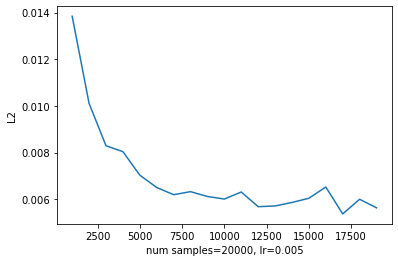

[0.013845058236271144, 0.010109811894595623, 0.008297054134309291, 0.008043441908434033, 0.007036673218011856, 0.006506281100213528, 0.006199369275942445, 0.006328315030783415, 0.0061222101859748366, 0.006011591034010053, 0.006313789740204811, 0.0056843010718002915, 0.005715545199811459, 0.005865351287648082, 0.00604548823647201, 0.006527735752053559, 0.00537493359297514, 0.0060030019413679836, 0.005635434896685183]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/walk_train_aug/shiftx_l2_git0.005/output/model_20000.ckpt")

[-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8]


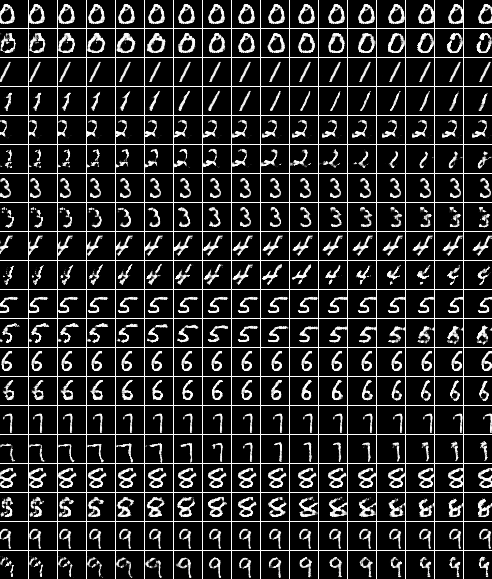

In [19]:
num_samples = 10
lower_bound = -8
a = np.arange(lower_bound, -lower_bound+1, 1)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))